In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import time
from matplotlib.animation import FuncAnimation
import time

class SpectrumEnvironment:
    def __init__(self, num_bands=10, steps=25,detection_method="energy_detection"):
        self.num_bands = num_bands  # Total number of frequency bands
        self.steps = steps
        self.channel_states = [[] for _ in range(num_bands)]
        self.transition_matrices = self._initialize_transition_matrices()
        self.total_reward = 0  # Track total reward
        self.rewards = []  # Track rewards for each step
        self.energy_costs = [[] for _ in range(num_bands)]
        self.total_energy = 0
        valid_methods = ["energy_detection", "matched_filter", "cyclostationary"]
        if detection_method not in valid_methods:
            raise ValueError(f"Invalid detection method. Choose from {valid_methods}")
        self.detection_method = detection_method
        self.state = self._generate_spectrum_state()  # Current state of the spectrum
        self.energy_detection_count = 0
    def _initialize_transition_matrices(self):
        """
        Generate a unique random Markov chain transition matrix for each band.
        Each matrix ensures that the probabilities in each row sum to 1.
        """
        matrices = []
        for _ in range(self.num_bands):
            # Generate a random 2x2 matrix
            random_matrix = np.random.rand(2, 2)
            # Normalize each row to sum to 1
            transition_matrix = random_matrix / random_matrix.sum(axis=1, keepdims=True)
            matrices.append(transition_matrix)
        return matrices
    
    def threshold_calculator(self,time_step):
        t = 0
        c = 0
        for i in range(self.num_bands):
            if len(self.energy_costs[i]) == 0:
                pass
            else:
                t+= self.energy_costs[i][-1]
                c+=1
        if c != 0:
            t = t/c
        return t
    def energy_detection(self, time_step, band, delta=0.1, noise_floor=0.05):
        """
        Perform energy detection for a specific band and timestep.
        Simulates energy detection with a noise floor threshold.
    
        Parameters:
        - time_step (int): The timestep to evaluate.
        - band (int): The band (channel) number to evaluate.
        - delta (float): The change in energy state for transitions (default: 0.1).
        - noise_floor (float): The noise floor threshold for detection (default: 0.05).
    
        Returns:
        - detection_result (int): 1 if channel is occupied, 0 otherwise.
        - energy (float): Calculated energy for the band and timestep.
        """
        # Ensure valid inputs
        if not (0 <= band < self.num_bands):
            raise ValueError("Band number out of range.")
        if not (0 <= time_step < self.steps):
            raise ValueError("Time step out of range.")
    
        # Current state and previous energy
        current_state = self.channel_states[band][time_step]
        previous_energy = self.energy_costs[band][-1] if self.energy_costs[band] else 0
    
        # Calculate new energy state
        new_energy = previous_energy + (delta if current_state == 1 else 0)
        self.energy_costs[band].append(new_energy)
    
        # Detection decision
        nr = self.threshold_calculator(time_step)
        detection_result = 1 if new_energy >= nr else 0
        return detection_result, new_energy

    def detect(self,time_step,band):
        if self.detection_method == "energy_detection":
            return self.energy_detection(time_step, band)
        elif self.detection_method == "matched_filter":
            pass
        elif self.detection_method == "cyclostationary":
            pass
    
    def _generate_spectrum_state(self):
        """
        Generate or regenerate spectrum states for all bands using Markov chain dynamics.
        Ensures a clean slate to avoid unintended accumulation of states.
        """
        # Clear existing states to ensure consistent initialization
        self.channel_states = [[] for _ in range(self.num_bands)]
        
        for band in range(self.num_bands):
            last_state = 0  # Start with a default state
            band_states = []
            
            for time_step in range(self.steps):
                # Determine the next state based on the Markov chain
                transition_probabilities = self.transition_matrices[band][last_state]
                next_state = np.random.choice([0, 1], p=transition_probabilities)
                band_states.append(next_state)
                last_state = next_state  # Update for the next step
            
            self.channel_states[band] = band_states
    
        return self.channel_states

    
    def step(self, time_step, action):
        """
        Execute an action, calculate reward, and return the next state, reward, and done flag.
    
        Parameters:
        - time_step (int): The current time step in the simulation.
        - action (int): The chosen action (index corresponds to detect/skip for each band).
    
        Returns:
        - next_state (tuple): The next state after performing the action.
        - reward (float): The reward for the action taken.
        - done (bool): Whether the episode has ended.
        """
        # Decode action into band and operation (detect/skip)
        num_actions_per_band = 2  # Detect or Skip
        band = action // num_actions_per_band
        operation = action % num_actions_per_band  # 0: Detect, 1: Skip
        raw_reward = 30 if self.channel_states[band][time_step] == 0 else 5
        
        if not (0 <= band < self.num_bands):
            raise ValueError("Band number out of range.")
        if not (0 <= time_step < self.steps):
            raise ValueError("Time step out of range.")
    
        # If "Skip," return a small penalty and proceed
        if operation == 1:  # Skip
            reward = raw_reward  # Small penalty for skipping
            next_state = (time_step + 1,) if time_step + 1 < self.steps else (self.steps - 1,)
            done = time_step + 1 >= self.steps
            return next_state, reward, done
    
        # "Detect" operation
        self.energy_detection_count += 1
        detection_result, energy_consumption = self.detect(time_step, band)
        if detection_result and self.channel_states[band][time_step] == 0:
            reward = raw_reward - energy_consumption
        elif not detection_result and self.channel_states[band] == 0:
            reward = raw_reward - energy_consumption
        else:
            reward = -raw_reward - energy_consumption
        # Update total reward
        self.total_reward += reward
        self.total_energy += energy_consumption
        # Calculate next state
        next_time_step = time_step + 1
        next_state = (next_time_step,) if next_time_step < self.steps else (self.steps - 1,)
        done = next_time_step >= self.steps
    
        return next_state, reward, done

    
    def soft_reset(self):
        self.energy_costs = [[] for _ in range(self.num_bands)]
        self.total_energy = 0
        self.energy_detection_count = 0

energy_detection


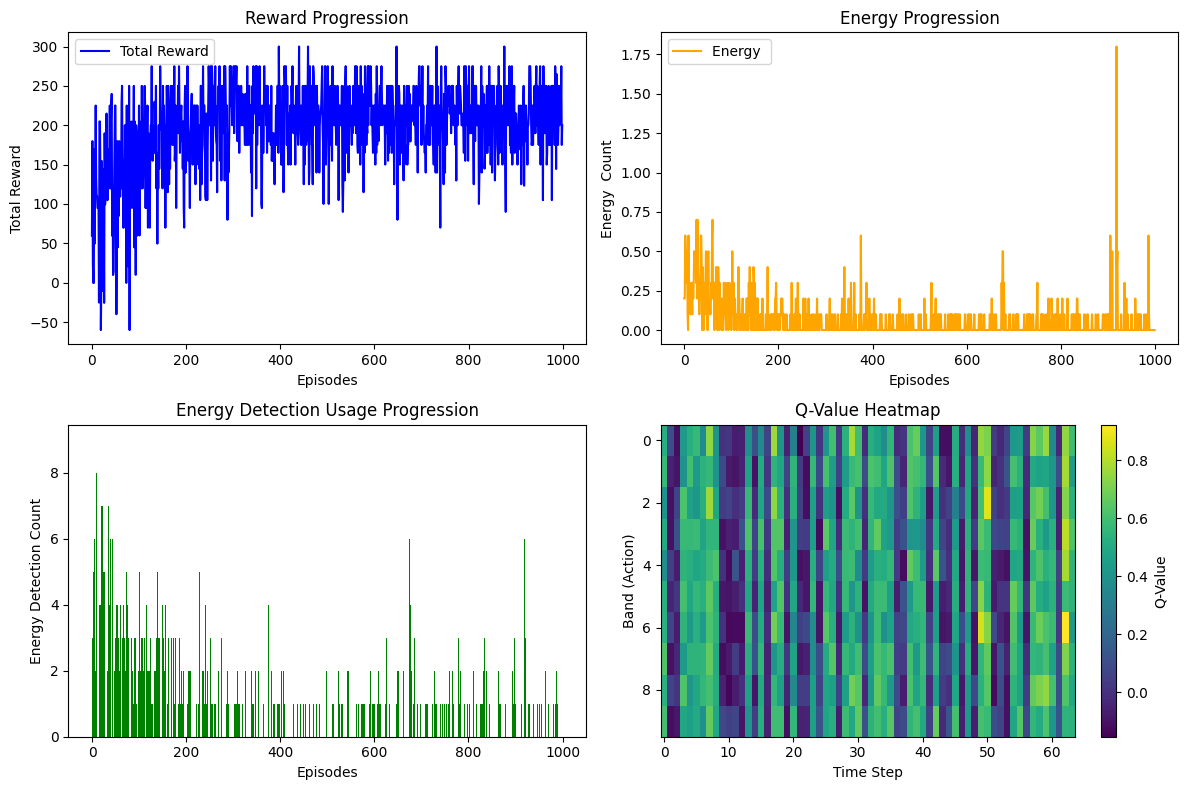

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
import torch.nn.functional as F

class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


# class QNetwork(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(QNetwork, self).__init__()
#         self.fc1 = nn.Linear(input_dim, 128)
#         self.fc2 = nn.Linear(128, 128)
#         self.fc3 = nn.Linear(128, 64)
#         self.fc4 = nn.Linear(64, output_dim)
# 
#         self.dropout = nn.Dropout(p=0.2)  # Dropout for regularization
# 
#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         #x = self.dropout(x)  # Regularization step
#         x = F.relu(self.fc3(x))
#         return self.fc4(x)  # Output layer

class DQNAgent:
    def __init__(self, env, alpha=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, batch_size=32, memory_size=10000):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.memory_size = memory_size

        # Input is time step; Output is 2 × num_bands (detect/skip for each band)
        self.q_network = QNetwork(input_dim=1, output_dim=2 * self.env.num_bands)
        self.target_network = QNetwork(input_dim=1, output_dim=2 * self.env.num_bands)
        self.target_network.load_state_dict(self.q_network.state_dict())

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.alpha)
        self.replay_buffer = deque(maxlen=self.memory_size)

        self.episode_rewards = []
        self.energy_detection_usage = []
        self.episode_energy = []
        self.action_counts = np.zeros(2 * self.env.num_bands)
        self.energy_detection_usage = []

    def choose_action(self, state):
        """
        Choose an action based on an epsilon-greedy policy.
        
        Parameters:
        - state (tuple): The current state, represented as (time_step,).
    
        Returns:
        - action (int): The chosen action (0 to 2 * num_bands - 1).
        """
        if random.random() < self.epsilon:
            return random.randint(0, 2 * self.env.num_bands - 1)
        else:
            state_tensor = torch.tensor([state[0]], dtype=torch.float32)  # Use time_step as input
            q_values = self.q_network(state_tensor)
            return torch.argmax(q_values).item()
    def store_experience(self, state, action, reward, next_state):
        self.replay_buffer.append((state, action, reward, next_state))

    def sample_experience(self):
        batch = random.sample(self.replay_buffer, self.batch_size)
        return [(state[0], action, reward, next_state[0]) for state, action, reward, next_state in batch]

    def update_q_network(self):
        if len(self.replay_buffer) < self.batch_size:
            return
    
        batch = self.sample_experience()
        states, actions, rewards, next_states = zip(*batch)
    
        # Convert to tensors
        states_tensor = torch.tensor(states, dtype=torch.float32).unsqueeze(1)
        actions_tensor = torch.tensor(actions, dtype=torch.int64)
        rewards_tensor = torch.tensor(rewards, dtype=torch.float32)
        next_states_tensor = torch.tensor(next_states, dtype=torch.float32).unsqueeze(1)
    
        # Compute Q-values and target Q-values
        q_values = self.q_network(states_tensor)
        next_q_values = self.target_network(next_states_tensor)
    
        q_value_for_actions = q_values.gather(1, actions_tensor.view(-1, 1)).squeeze(1)
        next_q_value_for_best_action = torch.max(next_q_values, dim=1)[0]
        target_q_values = rewards_tensor + self.gamma * next_q_value_for_best_action
    
        # Compute loss and update the network
        loss = nn.MSELoss()(q_value_for_actions, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def train(self, episodes=500):
        """
        Train the agent using Deep Q-Learning.
    
        Parameters:
        - episodes (int): Number of episodes for training.
        """
        for episode in range(episodes):
            self.env._generate_spectrum_state()
            self.env.soft_reset()
            total_reward = 0
    
            # Initialize the state as the first time step
            state = (0,)  # Start with time_step = 0
    
            for t in range(self.env.steps):
                action = self.choose_action(state)
                self.action_counts[action] += 1
                # Take the chosen action in the environment
                next_state, reward, done = self.env.step(state[0], action)
                # Store the experience in replay buffer
                self.store_experience(state, action, reward, next_state)
    
                # Update Q-network
                self.update_q_network()
    
                # Update state and accumulate reward
                state = next_state
                total_reward += reward
    
                if done:
                    break
    
            # Track performance
            self.episode_rewards.append(total_reward)
            self.episode_energy.append(self.env.total_energy)
            self.energy_detection_usage.append(self.env.energy_detection_count)
            # Decay epsilon (exploration rate)
            self.epsilon = max(0.1, self.epsilon * self.epsilon_decay)
    
            # Update target network periodically
            if episode % 10 == 0:
                self.target_network.load_state_dict(self.q_network.state_dict())
            #print(f"Episode {episode + 1}/{episodes}: Reward = {total_reward}, Epsilon = {self.epsilon}")
    def visualize_results(self):
        episodes = len(self.episode_rewards)

        plt.figure(figsize=(12, 8))
        # Plot Total Rewards per Episode
        plt.subplot(2, 2, 1)
        plt.plot(range(episodes), self.episode_rewards, label="Total Reward", color="blue")
        plt.xlabel("Episodes")
        plt.ylabel("Total Reward")
        plt.title("Reward Progression")
        plt.legend()
        
        plt.subplot(2, 2, 2)
        plt.plot(range(episodes), self.episode_energy, label="Energy ", color="orange")
        plt.xlabel("Episodes")
        plt.ylabel("Energy  Count")
        plt.title("Energy Progression")
        plt.legend()
        
        # Plot Action Selection Frequency
        plt.subplot(2, 2, 3)
        plt.bar(range(episodes), self.energy_detection_usage, color="green")
        plt.xlabel("Episodes")
        plt.ylabel("Energy Detection Count")
        plt.title("Energy Detection Usage Progression")

        # Plot Q-Value Heatmap
        plt.subplot(2, 2, 4)
        q_table = self.q_network.fc3.weight.data.cpu().numpy()
        plt.imshow(q_table, aspect="auto", cmap="viridis", interpolation="nearest")
        plt.colorbar(label="Q-Value")
        plt.xlabel("Time Step")
        plt.ylabel("Band (Action)")
        plt.title("Q-Value Heatmap")

        plt.tight_layout()
        plt.show()

for i in ["energy_detection"]:
    print(i)
    env = SpectrumEnvironment(num_bands=5, steps=10,detection_method=i)
    agent = DQNAgent(env)
    agent.train(episodes=1000)
    agent.visualize_results()